In [23]:
%load_ext autoreload
%autoreload 2

from ocean_navigation_simulator.generative_error_model.generative_model_metrics import rmse_over_time_xr, rmse_over_time, vector_correlation_over_time_xr, vector_correlation_over_time
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Compute Synthetic RMSE

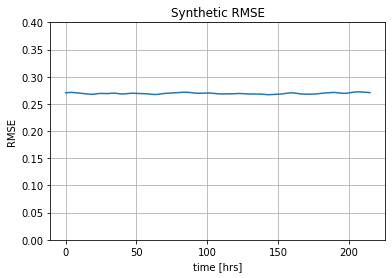

In [2]:
error_data_root = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/synthetic_error/area1"
files = os.listdir(error_data_root)
rmse = []
for file in files:
    data = xr.open_dataset(os.path.join(error_data_root, file))
    rmse.append(rmse_over_time_xr(data, variables=("u_error", "v_error")))
rmse = np.array(rmse).mean(axis=0)

plt.plot(range(len(rmse)), rmse)
plt.ylim([0, 0.4])
plt.title("Synthetic RMSE")
plt.ylabel("RMSE")
plt.xlabel("time [hrs]")
plt.grid()

## Compute Empirical RMSE

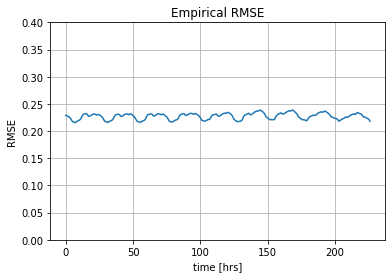

In [3]:
error_data_root = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/dataset_forecast_error/area1"
files = sorted(os.listdir(error_data_root))
rmse_data = []
for file in files[:50]:
    data = pd.read_csv(os.path.join(error_data_root, file))
    rmse_data.append(rmse_over_time(data, variables=("u_error", "v_error"))["rmse"])
# take average for each hour
rmse_data = np.array(rmse_data).mean(axis=0)

plt.plot(range(len(rmse_data)), rmse_data)
plt.ylim([0, 0.4])
plt.title("Empirical RMSE")
plt.ylabel("RMSE")
plt.xlabel("time [hrs]")
plt.grid()

## Compute Synthetic Vector Correlation

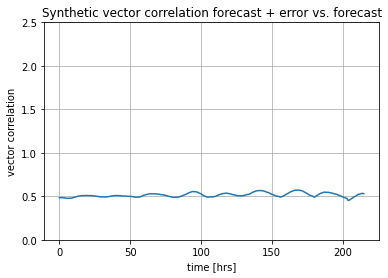

In [20]:
# forecast + synth error vs forecast

error_data_root = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/synthetic_error/area1"
error_files = sorted(os.listdir(error_data_root))

forecast_root = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/forecasts/area1"
forecast_files = sorted(os.listdir(forecast_root))[:len(error_files)]

vec_corr = []
for error_file, forecast_file in zip(error_files, forecast_files):
    error_data = xr.open_dataset(os.path.join(error_data_root, error_file))
    forecast_data = xr.open_dataset(os.path.join(forecast_root, forecast_file))
    temp_vec_corr = vector_correlation_over_time_xr(error_data, forecast_data)
    vec_corr.append(temp_vec_corr)
vec_corr = np.array(vec_corr).mean(axis=0)

plt.plot(range(len(vec_corr)), vec_corr)
plt.ylim([0, 2.5])
plt.title("Synthetic vector correlation forecast + error vs. forecast")
plt.xlabel("time [hrs]")
plt.ylabel("vector correlation")
plt.grid()

## Compute Empirical Vector Correlation

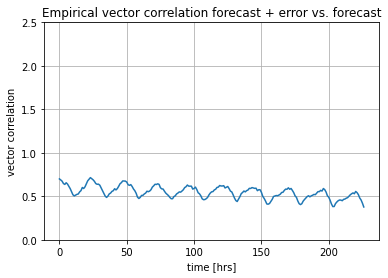

In [24]:
# use forecast error + forecast or alternatively buoy data directly
# use forecast+error vs forecast

forecast_error_root = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/dataset_forecast_error/area1"
error_files = sorted(os.listdir(forecast_error_root))[:20]
vec_corr = []
for file in error_files:
    data = pd.read_csv(os.path.join(forecast_error_root, file))
    vec_corr.append(vector_correlation_over_time(data))
vec_corr = np.array(vec_corr).mean(axis=0)

plt.plot(range(len(vec_corr)), vec_corr)
plt.ylim([0, 2.5])
plt.title("Empirical vector correlation forecast + error vs. forecast")
plt.xlabel("time [hrs]")
plt.ylabel("vector correlation")
plt.grid()

## Sample from Simplex Noise Sample and compute Variogram

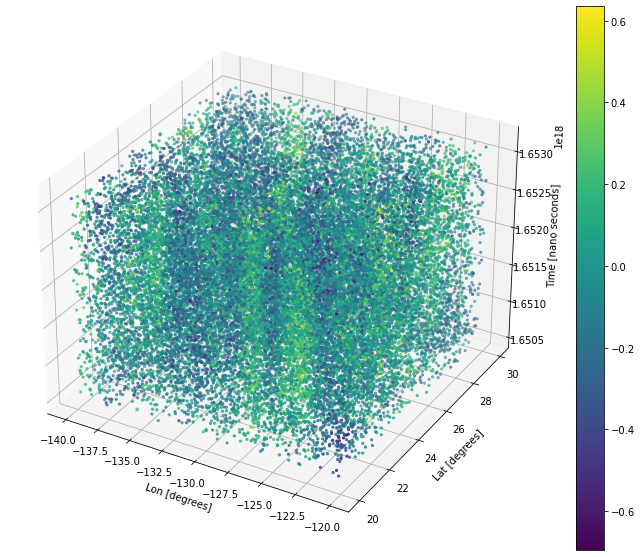

In [2]:
import os
import xarray as xr
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# noise_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/synthetic_error/area1"
# files = sorted(os.listdir(noise_dir))
# data = xr.load_dataset(os.path.join(noise_dir, files[0]))
data = xr.load_dataset("~/Downloads/plots/forecast_validation/vec_sample_noise.nc")
lon_len = len(data["lon"].values)
lat_len = len(data["lat"].values)
time_len = len(data["time"].values)
total_len = lon_len * lat_len * time_len

idx = np.random.choice(list(range(total_len)), size=30000)

lon = data["lon"].values.reshape(-1)
lat = data["lat"].values.reshape(-1)
time = data["time"].values.reshape(-1)

axes = np.array(list(itertools.product(lon, lat, time)))[idx]
lon = axes[:, 0]
lat = axes[:, 1]
time = axes[:, 2]
u_error = data["u_error"].values.reshape(-1)[idx]
v_error = data["v_error"].values.reshape(-1)[idx]

data = pd.DataFrame({"lon": lon,
                     "lat": lat,
                     "time": time,
                     "u_error": u_error,
                     "v_error": v_error})

time_plot = np.array(time, dtype=np.int64)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection="3d")
plot = ax.scatter(lon, lat, time_plot, c=u_error, marker=".")
ax.set_xlabel("Lon [degrees]")
ax.set_ylabel("Lat [degrees]")
ax.set_zlabel("Time [nano seconds]")
plt.colorbar(plot, ax=ax)

In [5]:
from ocean_navigation_simulator.generative_error_model.variogram.Variogram import Variogram
from ocean_navigation_simulator.generative_error_model.variogram.VisualizeVariogram import VisualizeVariogram

print(data)
v = Variogram(data)
v.detrend()
bins, bins_count = v.build_variogram_gen((5, 1), num_workers=2, chunk_size=int(1e6), cross_buoy_pairs_only=False, is_3d=False)
vvis = VisualizeVariogram(None, variogram=v)

              lon        lat                time   u_error   v_error
0          -133.5  25.916667 2022-05-06 12:30:00 -0.197548 -0.197548
1     -131.333333  22.416667 2022-05-08 14:30:00 -0.021384 -0.021384
2          -137.0      29.25 2022-05-11 14:30:00 -0.093311 -0.093311
3     -128.583333  26.583333 2022-05-11 05:30:00 -0.014383 -0.014383
4         -125.25  22.666667 2022-05-14 23:30:00 -0.178860 -0.178860
...           ...        ...                 ...       ...       ...
29995 -121.833333  25.583333 2022-05-21 07:30:00 -0.062564 -0.062564
29996 -129.166667  25.333333 2022-05-15 01:30:00 -0.124776 -0.124776
29997 -138.083333  21.166667 2022-04-28 16:30:00  0.075203  0.075203
29998      -138.5  24.333333 2022-05-06 20:30:00 -0.254372 -0.254372
29999      -121.5      23.75 2022-04-28 19:30:00  0.059437  0.059437

[30000 rows x 5 columns]


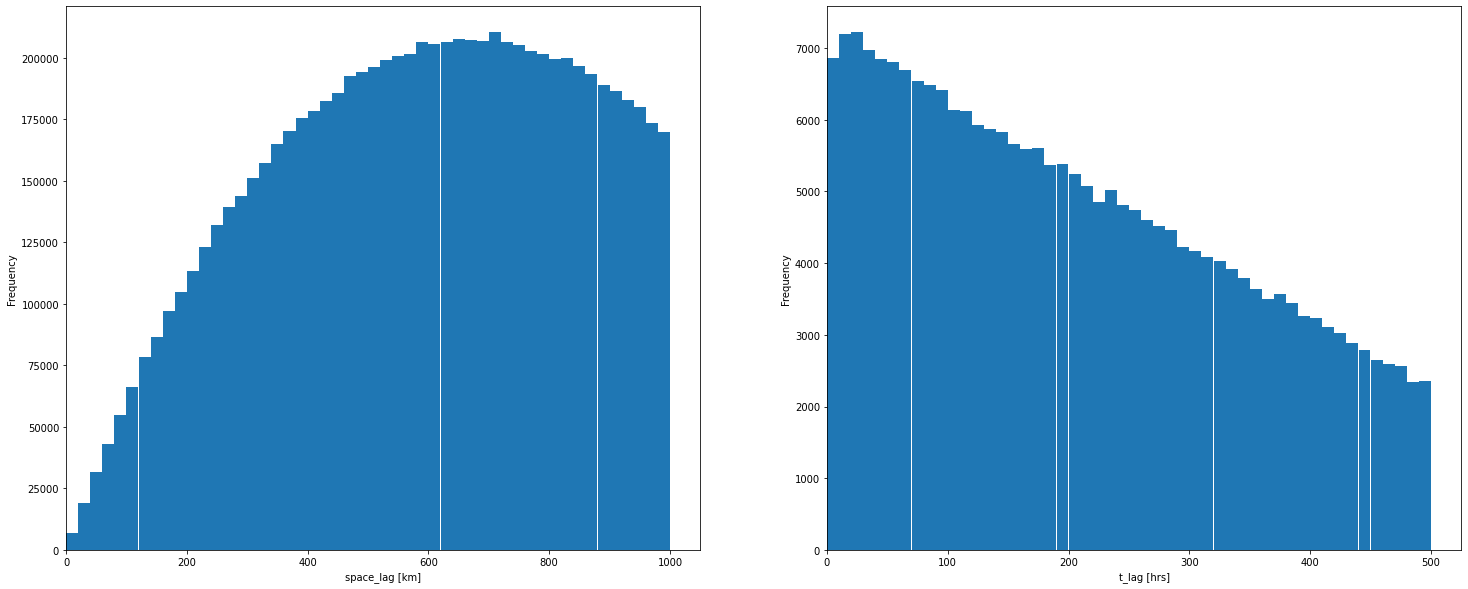

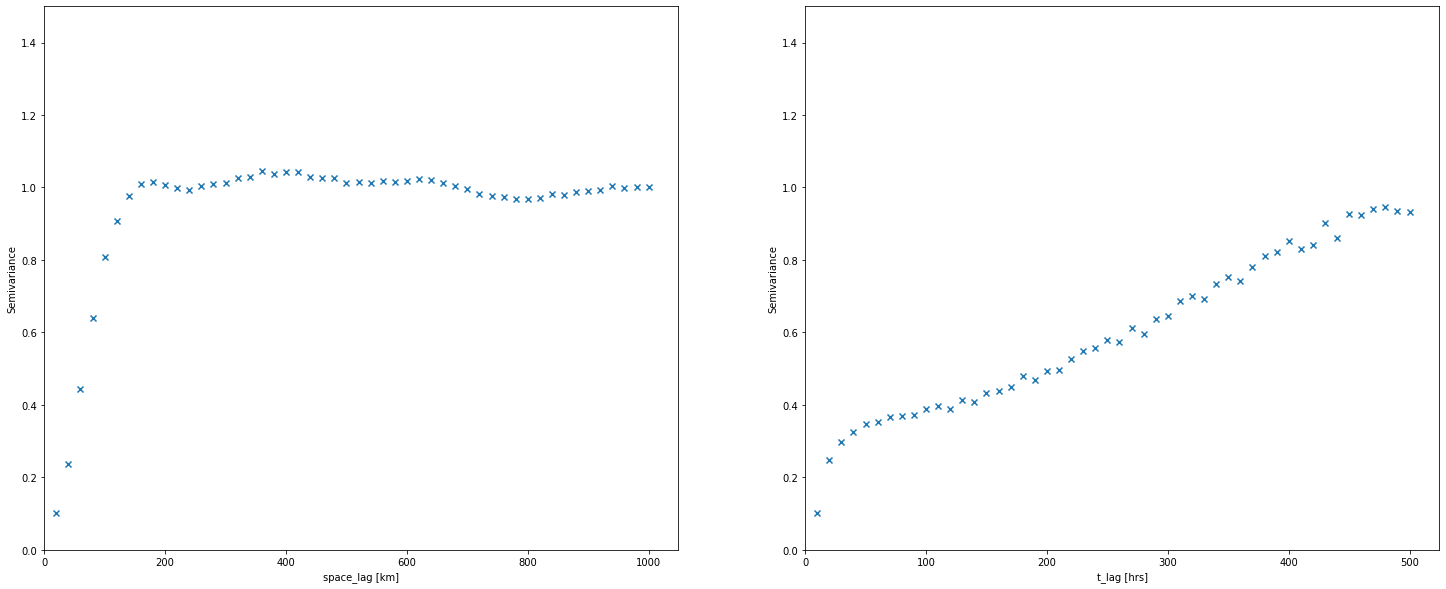

In [6]:
vvis.decrease_variogram_res((20, 10))
view_range = [1000, 500]
vvis.plot_histograms(view_range=view_range)
vvis.plot_variograms(view_range=view_range)

## Compute stats of opensimplex

In [34]:
import opensimplex
import numpy as np

simplex_gen = opensimplex.OpenSimplex(seed=12345678)
num_pts = int(2e2)
num_of_loops = 100
means = []
sum = 0
sumsq = 0
for i in range(num_of_loops):
    rand_x = np.random.uniform(0, 1000, num_pts)
    rand_y = np.random.uniform(0, 1000, num_pts)
    rand_z = np.random.uniform(0, 1000, num_pts)
    rand_t = np.random.uniform(0, 1000, num_pts)
    samples = np.array(simplex_gen.noise3array(rand_x, rand_y, rand_z))
    means.append(samples.mean())
    sum += samples.sum()
    sumsq += np.square(samples).sum()

print(np.array(means).mean())
print((sumsq - (sum * sum)/(num_of_loops*num_pts**3))/(num_of_loops*num_pts**3))

-7.076037679000259e-06
0.09792579099296904
